In [1]:
import os

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from scripts import constants
from scripts.eval_utils import evaluate_latent_representations

Global seed set to 0


In [2]:
results_path = constants.DEFAULT_RESULTS_PATH
data_path = constants.DEFAULT_DATA_PATH
split_lookup = constants.DATASET_SPLIT_LOOKUP
seeds = constants.DEFAULT_SEEDS

dataset = "papalexi_2021"
latent_size = 10
split_key = split_lookup[dataset]["split_key"]
background_value = split_lookup[dataset]["background_value"]

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        data_path,
        f"{dataset}/preprocessed/adata_top_2000_genes_tc.h5ad",
    )
)
target_adata = adata[adata.obs[split_key] != background_value].copy()

In [4]:
# Modify data for consistent and comprehensible labels.
target_adata.obs["phase"] = target_adata.obs["Phase"]
target_adata.obs["replicate"] = (
    target_adata.obs["replicate"]
    .replace(to_replace={f"rep{i}": f"Replicate {i}" for i in range(1, 4)})
)

In [5]:
# Ground truth salient labels.
target_adata.obs["perturbation_cluster"] = "Others"
target_adata.obs.loc[target_adata.obs["gene"] == "IRF1", "perturbation_cluster"] = "IRF1"
target_adata.obs.loc[
    target_adata.obs["gene"].isin(
        [
        "IFNGR1",
        "IFNGR2",
        "JAK2",
        "STAT1",
        ]
    ), "perturbation_cluster"
] = r'Upstream of IFN-$\gamma$'

perturbation_labels = target_adata.obs["perturbation_cluster"]
perturbation_labels = LabelEncoder().fit_transform(perturbation_labels)

# Replicate labels.
replicate_labels = target_adata.obs["replicate"]
replicate_labels = LabelEncoder().fit_transform(replicate_labels)

# Cell cycle labels.
phase_labels = target_adata.obs["phase"]
phase_labels = LabelEncoder().fit_transform(phase_labels)

target_label_dict = {
    "perturbation_cluster": perturbation_labels,
    "replicate": replicate_labels,
    "phase": phase_labels,
}

In [6]:
metric_list = [
    "silhouette",
    "adjusted_rand_index",
    "normalized_mutual_info",
    "unsupervised_cluster_accuracy",
]

In [7]:
# Store and evaluate latent representations.
contrastive_methods = ["total_contrastiveVI"]
non_contrastive_methods = ["totalVI"]
methods = non_contrastive_methods + contrastive_methods

rep_dict = {
    **{
        f"{method}_{kind}": []
        for method in contrastive_methods
        for kind in ["salient", "shared"]
    },
    **{
        f"{method}_latent": []
        for method in non_contrastive_methods
    }
}
performance_dict = {
    f"{rep}_{label}_{metric}": []
    for rep in rep_dict.keys()
    for label in target_label_dict.keys()
    for metric in metric_list
}

for method in methods:
    for seed in tqdm(seeds):
        rep_dir = os.path.join(
            results_path,
            dataset,
            method,
            f"latent_{latent_size}",
            f"{seed}",
        )
        trial_rep_dict = {}
        latent_rep = np.load(
            os.path.join(rep_dir, "latent_representations.npy")
        )
        if method in contrastive_methods:
            shared_rep = np.load(
                os.path.join(rep_dir, "shared_latent_representations.npy")
            )
            trial_rep_dict = {"salient": latent_rep, "shared": shared_rep}
        else:
            trial_rep_dict = {"latent": latent_rep}
        
        for rep_kind, trial_rep in trial_rep_dict.items():
            rep_key = f"{method}_{rep_kind}"
            rep_dict[rep_key].append(trial_rep)
            
            for label_name, labels in target_label_dict.items():
                trial_performance = evaluate_latent_representations(
                    labels,
                    trial_rep,
                    clustering_seed=123,
                    cluster_algorithm="kmeans",
                )
                for metric in metric_list:
                    performance_key = f"{method}_{rep_kind}_{label_name}_{metric}"
                    performance_dict[performance_key].append(trial_performance[metric])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:43<00:00, 56.79s/it]


In [8]:
performance_stat_dict = {}
for key, val in performance_dict.items():
    mean = np.mean(val)
    std = np.std(val)
    stderr = std / np.sqrt(len(val))
    performance_stat_dict[key] = {
        "mean": mean,
        "std": std,
        "stderr": stderr,
    }

In [9]:
format_rep_str = {
    "totalVI_latent": "totalVI",
    "total_contrastiveVI_shared": "total-contrastiveVI\n(Shared)",
    "total_contrastiveVI_salient": "total-contrastiveVI\n(Salient)",
}
format_metric_str = {
    "silhouette": "Silhouette",
    "adjusted_rand_index": "ARI",
    "normalized_mutual_info": "NMI",
    # "unsupervised_cluster_accuracy": "UCA",
}
format_target_label_str = {
    "replicate": "Replicate",
    "phase": "Cell Cycle",
    "perturbation_cluster": "Perturbation Cluster",
}
metric_list = list(format_metric_str.keys())
target_label_list = list(format_target_label_str.keys())

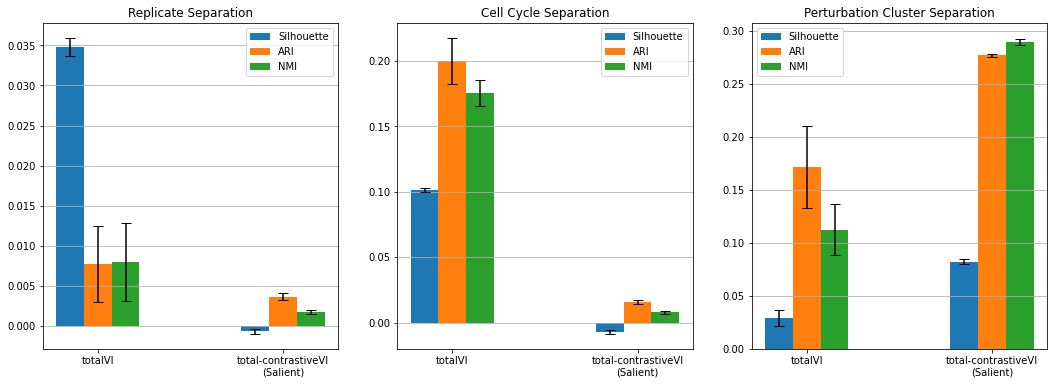

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
width = 0.15  # Bar width
capsize = 5  # Error bar width
var_statistic = "stderr"

plot_format_rep_str = {
    "totalVI_latent": "totalVI",
    "total_contrastiveVI_salient": "total-contrastiveVI\n(Salient)",
}

x = np.arange(len(plot_format_rep_str.keys()))

for i, ax in enumerate(axes):
    target_label = target_label_list[i]
    
    for j, metric in enumerate(metric_list):
        mean_list = [
            performance_stat_dict[f"{rep}_{target_label}_{metric}"]["mean"]
            for rep in plot_format_rep_str.keys()
        ]
        var_list = [
            performance_stat_dict[f"{rep}_{target_label}_{metric}"][var_statistic]
            for rep in plot_format_rep_str.keys()
        ]
        
        ax.bar(
            x + width * j,
            mean_list,
            width,
            yerr=var_list,
            capsize=capsize,
            label=format_metric_str[metric],
        )

    xticklabels = list(plot_format_rep_str.values())
    
    ax.set_xticks(x + 1.0 * width)
    ax.set_xticklabels(xticklabels)
    if i < 2:
        ax.legend(loc="upper right")
    else:
        ax.legend(loc="upper left")
    ax.grid(axis="y")
    ax.set_title(f"{format_target_label_str[target_label]} Separation")
plt.show()

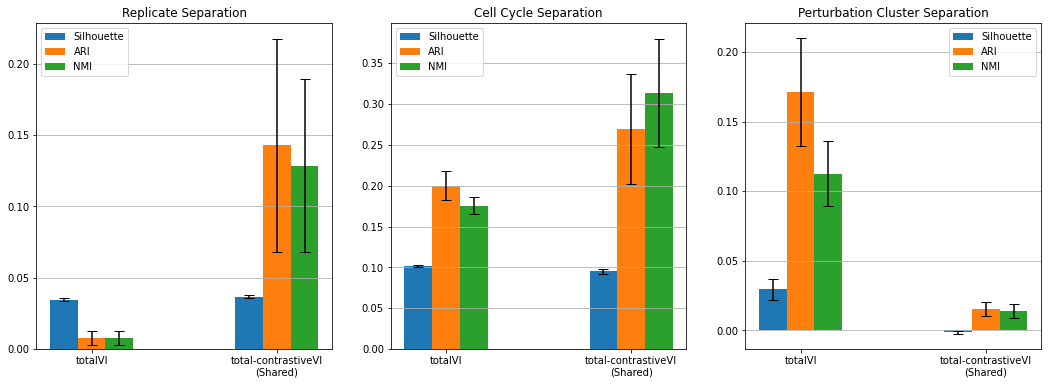

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
width = 0.15  # Bar width
capsize = 5  # Error bar width
var_statistic = "stderr"

plot_format_rep_str = {
    "totalVI_latent": "totalVI",
    "total_contrastiveVI_shared": "total-contrastiveVI\n(Shared)",
}

x = np.arange(len(plot_format_rep_str.keys()))

for i, ax in enumerate(axes):
    target_label = target_label_list[i]
    
    for j, metric in enumerate(metric_list):
        mean_list = [
            performance_stat_dict[f"{rep}_{target_label}_{metric}"]["mean"]
            for rep in plot_format_rep_str.keys()
        ]
        var_list = [
            performance_stat_dict[f"{rep}_{target_label}_{metric}"][var_statistic]
            for rep in plot_format_rep_str.keys()
        ]
        
        ax.bar(
            x + width * j,
            mean_list,
            width,
            yerr=var_list,
            capsize=capsize,
            label=format_metric_str[metric],
        )

    xticklabels = list(plot_format_rep_str.values())
    
    ax.set_xticks(x + 1.0 * width)
    ax.set_xticklabels(xticklabels)
    if i < 2:
        ax.legend(loc="upper left")
    else:
        ax.legend(loc="upper right")
    ax.grid(axis="y")
    ax.set_title(f"{format_target_label_str[target_label]} Separation")
plt.show()

In [12]:
seed_index = 0
latent_rep = rep_dict["totalVI_latent"][seed_index]
shared_rep = rep_dict["total_contrastiveVI_shared"][seed_index]
salient_rep = rep_dict["total_contrastiveVI_salient"][seed_index]

latent_rep_adata = ad.AnnData(
    X=latent_rep,
    obs=target_adata.obs,
    var=pd.DataFrame(
        index=[f"latent_dim_{i}" for i in range(latent_size)]
    ),
)
sc.pp.neighbors(latent_rep_adata)
sc.tl.umap(latent_rep_adata)

shared_rep_adata = ad.AnnData(
    X=shared_rep,
    obs=target_adata.obs,
    var=pd.DataFrame(
        index=[f"latent_dim_{i}" for i in range(latent_size)]
    ),
)
sc.pp.neighbors(shared_rep_adata)
sc.tl.umap(shared_rep_adata)

salient_rep_adata = ad.AnnData(
    X=salient_rep,
    obs=target_adata.obs,
    var=pd.DataFrame(
        index=[f"latent_dim_{i}" for i in range(latent_size)]
    ),
)
sc.pp.neighbors(salient_rep_adata)
sc.tl.umap(salient_rep_adata)

2022-05-04 08:09:33.575571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /homes/gws/clin25/miniconda3/lib:/usr/lib/java/apache-maven-3.6.3/bin:/usr/lib/java/apache-ant-1.10.8/bin:/homes/gws/clin25/miniconda3/bin:/homes/gws/clin25/miniconda3/condabin:/usr/kerberos/sbin:/usr/kerberos/bin:/usr/lib/java/apache-maven-3.6.3/bin:/usr/lib/java/apache-ant-1.10.8/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/homes/gws/clin25/.local/bin:/homes/gws/clin25/bin
2022-05-04 08:09:33.575599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
label_palett_dict = {
    "replicate": ["mediumslateblue", "mediumvioletred", "mediumaquamarine"],
    "phase": ["rosybrown", "mediumseagreen", "palevioletred"],
    "perturbation_cluster": ["firebrick", "orchid", "moccasin"],
}

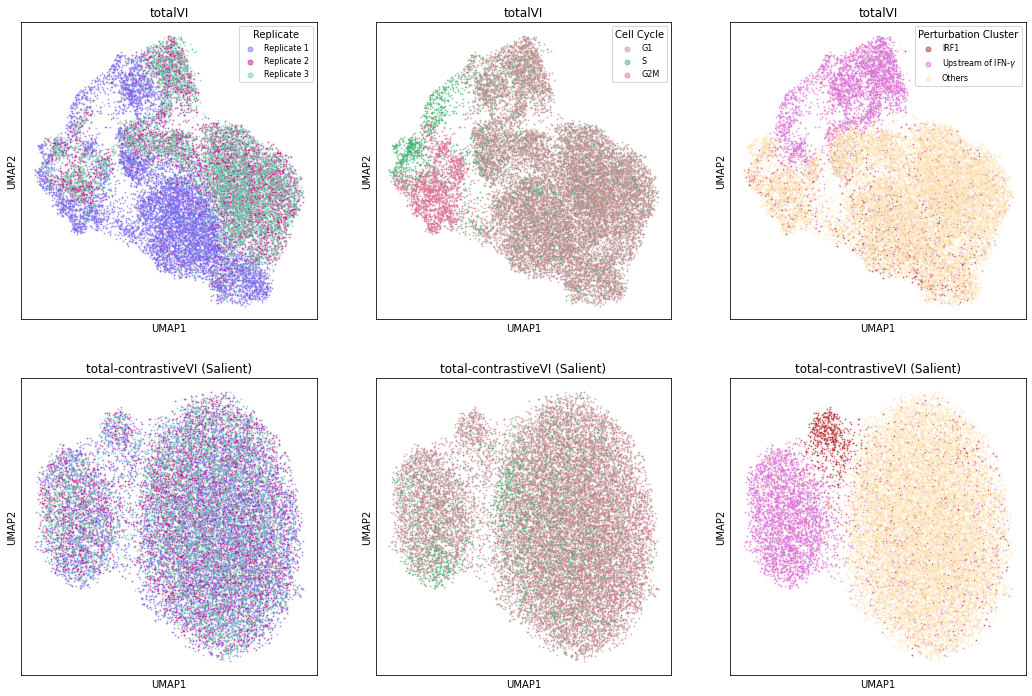

In [16]:
fig, (axes_1, axes_2) = plt.subplots(2, 3, figsize=(18, 12))
alpha = 0.5

for i, label_name in enumerate(format_target_label_str.keys()):
    label_values = target_adata.obs[label_name]
    unique_labels = sorted(label_values.unique())
    
    if "Others" in unique_labels:
        unique_labels.remove("Others")
        unique_labels += ["Others"]
    if "G2M" in unique_labels:
        unique_labels.remove("G2M")
        unique_labels += ["G2M"]
        
    ax = axes_1[i]
    
    for j, label in enumerate(unique_labels):
        ax.scatter(
            latent_rep_adata.obsm["X_umap"][:, 0][label_values == label],
            latent_rep_adata.obsm["X_umap"][:, 1][label_values == label],
            s=1,
            label=label,
            alpha=alpha,
            color=label_palett_dict[label_name][j],
        )
        ax.set_title("totalVI")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.legend(
            markerscale=5,
            fontsize=8,
            loc="upper right",
            title=format_target_label_str[label_name],
        )
        
        
for i, label_name in enumerate(format_target_label_str.keys()):
    label_values = target_adata.obs[label_name]
    unique_labels = sorted(label_values.unique())
    
    if "Others" in unique_labels:
        unique_labels.remove("Others")
        unique_labels += ["Others"]
    if "G2M" in unique_labels:
        unique_labels.remove("G2M")
        unique_labels += ["G2M"]
        
    ax = axes_2[i]
    
    for j, label in enumerate(unique_labels):
        ax.scatter(
            salient_rep_adata.obsm["X_umap"][:, 0][label_values == label],
            salient_rep_adata.obsm["X_umap"][:, 1][label_values == label],
            s=1,
            label=label,
            alpha=alpha,
            color=label_palett_dict[label_name][j],
        )
        ax.set_title("total-contrastiveVI (Salient)")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")

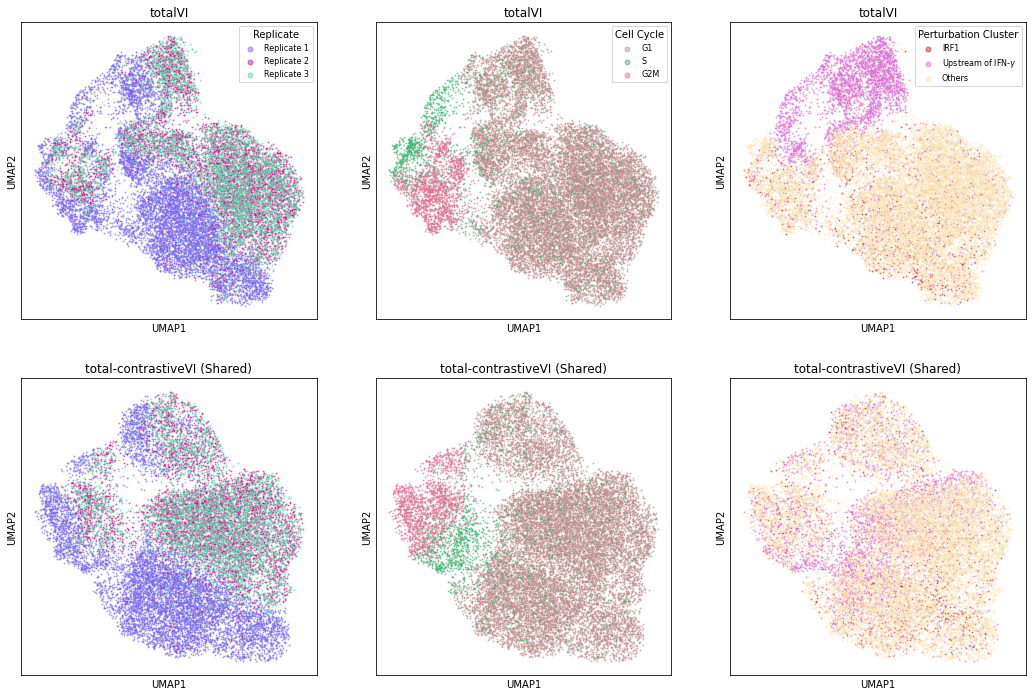

In [18]:
fig, (axes_1, axes_2) = plt.subplots(2, 3, figsize=(18, 12))
alpha = 0.5

for i, label_name in enumerate(format_target_label_str.keys()):
    label_values = target_adata.obs[label_name]
    unique_labels = sorted(label_values.unique())
    
    if "Others" in unique_labels:
        unique_labels.remove("Others")
        unique_labels += ["Others"]
    if "G2M" in unique_labels:
        unique_labels.remove("G2M")
        unique_labels += ["G2M"]
        
    ax = axes_1[i]
    
    for j, label in enumerate(unique_labels):
        ax.scatter(
            latent_rep_adata.obsm["X_umap"][:, 0][label_values == label],
            latent_rep_adata.obsm["X_umap"][:, 1][label_values == label],
            s=1,
            label=label,
            alpha=alpha,
            color=label_palett_dict[label_name][j],
        )
        ax.set_title("totalVI")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.legend(
            markerscale=5,
            fontsize=8,
            loc="upper right",
            title=format_target_label_str[label_name],
        )
        
        
for i, label_name in enumerate(format_target_label_str.keys()):
    label_values = target_adata.obs[label_name]
    unique_labels = sorted(label_values.unique())
    
    if "Others" in unique_labels:
        unique_labels.remove("Others")
        unique_labels += ["Others"]
    if "G2M" in unique_labels:
        unique_labels.remove("G2M")
        unique_labels += ["G2M"]
        
    ax = axes_2[i]
    
    for j, label in enumerate(unique_labels):
        ax.scatter(
            shared_rep_adata.obsm["X_umap"][:, 0][label_values == label],
            shared_rep_adata.obsm["X_umap"][:, 1][label_values == label],
            s=1,
            label=label,
            alpha=alpha,
            color=label_palett_dict[label_name][j],
        )
        ax.set_title("total-contrastiveVI (Shared)")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")